In [1]:
import emip_toolkit as EMTK
from IPython.display import Image
import correction
import random 
import numpy as np
import PIL
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
img = Image(filename= 'synthetic_text.png')
# img

In [6]:
image_path =''
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")
aoi.head()

,kind,name,x,y,width,height,image
0,sub-line,line 1 part 1,626.5,5,63,32,synthetic_text2.png
1,sub-line,line 1 part 2,692.5,5,146,32,synthetic_text2.png
2,sub-line,line 1 part 3,841.5,5,117,32,synthetic_text2.png
3,sub-line,line 1 part 4,960.5,5,65,32,synthetic_text2.png
4,sub-line,line 1 part 5,1027.5,5,27,32,synthetic_text2.png


In [7]:
file_path = ''
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()

,kind,name,x,y,width,height,image,token
0,sub-line,line 1 part 1,626.5,5,63,32,synthetic_text2.png,THE
1,sub-line,line 1 part 2,692.5,5,146,32,synthetic_text2.png,BEAVER'S
2,sub-line,line 1 part 3,841.5,5,117,32,synthetic_text2.png,LESSON
3,sub-line,line 1 part 4,960.5,5,65,32,synthetic_text2.png,(part
4,sub-line,line 1 part 5,1027.5,5,27,32,synthetic_text2.png,5)


In [8]:
line_ys = correction.find_lines_Y(aois_with_tokens)

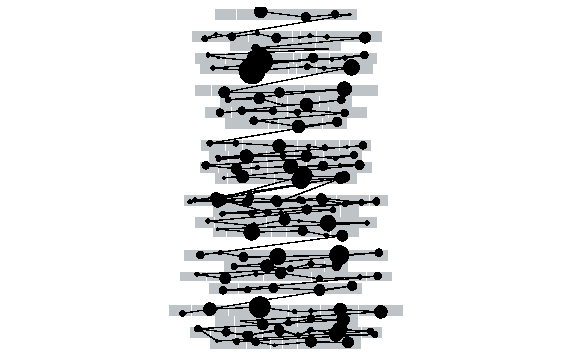

In [9]:
# generate generic visualizations of the trial
synth_fixations = correction.generate_fixations_lr_skip_regression(aois_with_tokens)
im = correction.fix_to_img_general('synthetic_text.png', synth_fixations, aois_with_tokens)
plt.figure(figsize=(10,7.5))
plt.axis('off')
plt.imshow(np.asarray(im), interpolation='nearest')
plt.show()

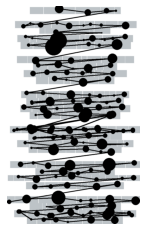

In [10]:
# crop the white space
from PIL import Image, ImageChops

def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

# im = Image.open("bord3.jpg")
im_trim = trim(im)
plt.axis('off')
plt.imshow(im_trim)
plt.show()

In [11]:
input_shape = np.asarray(im_trim).shape

input_x = input_shape[0]
input_y = input_shape[1]

n = 20 # scale of increments AND number of samples for each step-wise increment

if input_x > 800 or input_y > 800:
    input_x = input_x//2
    input_y = input_y//2

num_train = 5*11*n
    
x_train = np.zeros((num_train, input_x, input_y, 3), dtype=np.uint8)
y_train = np.zeros(num_train, dtype=int)

error_types = [0, 1, 2, 3, 4]

#### Generate training set

In [23]:
prev = 0

for i in range(len(error_types)): 
    for j in range(0, 11): 
        for index in range(n):
          w = i*11*n + j*n + index
          
          # double check the index in x_train is correct
          if w < prev:
            print(i, j, index, w, prev)
            exit()
          else:
            prev = w
            
          error_trial = correction.make_error_trial(error_types[i], j+index*1/n, aois_with_tokens)
          if j == 0 and index == 0:
           y_train[w] = 4
          else:
           y_train[w] = error_types[i]

          preped_img = correction.prep_image('synthetic_text.png', error_trial, aois_with_tokens, input_x, input_y)

          x_train[w] = preped_img

          # plt.imshow(x_train[index])


np.save("data/x_train_mix_ayn.npy", x_train)
np.save("data/y_train_mix_ayn.npy",y_train)

3


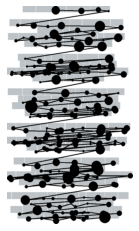

In [24]:
# example of the input of a trial with an error
a = 800
plt.imshow(x_train[a])
plt.axis("off")
print(y_train[a])

#### Generate Test set

In [12]:
n_test = 500

x_test = np.zeros((n_test, input_x, input_y, 3), dtype=np.uint8)
y_test = np.zeros(n_test, dtype=int)

In [14]:
for i in range(n_test):
    error = random.choice(error_types)
    factor = random.randint(0, 11)

    error_trial = correction.make_error_trial(error, factor, aois_with_tokens)
    
    if factor == 0:
        y_test[i] = 4
    else:
        y_test[i] = error

    preped_img = correction.prep_image('synthetic_text.png', error_trial, aois_with_tokens, input_x, input_y)
    x_test[i] = preped_img

np.save("data/x_test_mix_ayn.npy", x_test)
np.save("data/y_test_mix_ayn.npy", y_test)

4


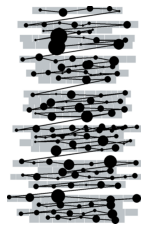

In [15]:
t = 105
plt.imshow(x_test[t])
plt.axis("off")
print(y_test[t])